In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

sys.path.append('/Users/ozdil/Desktop/GIT/df3dPostProcessing')
from df3dPostProcessing import df3dPostProcess

from SensitivityAnalysis.sensitivity_analysis import (calculate_forces, calculate_MSE_joints, calculate_statistics_joints, calculate_stats, calculate_stack_array)
from SensitivityAnalysis.plotting import (plot_mu_sem, heatmap_plot, plot_kp_joint, plot_stance_force)
from SensitivityAnalysis.process import (load_data, load_pickle, save_pickle, get_physics_data)

ImportError: cannot import name 'plot_heatmap' from 'SensitivityAnalysis.plotting' (/Users/ozdil/Desktop/GIT/NeuroMechFy1x/NeuroMechFly/scripts/SensitivityAnalysis/SensitivityAnalysis/plotting.py)

In [ ]:
joints = ['Coxa', 'Coxa_yaw', 'Coxa_roll', 'Femur', 'Femur_roll', 'Tibia', 'Tarsus1']
legs = ['LF', 'LM', 'LH', 'RF', 'RM', 'RH']

In [27]:
#: Set path where the pybullet results are located and the gain range used for experiments
load_path = '../KM/try'
save_path = './PyBulletData_wo_Vel/pybullet_data.pkl'
gain = np.arange(0.1, 1.1, 0.1)
READ_DATA= True

pybullet_data = get_physics_data(load_path, save_path, READ_DATA)

#: Load baseline files 
baseline_position = load_pickle('./7sc_nameconv_walking_joint_angle.pkl')  
baseline_velocity = load_pickle('./7sc_nameconv_walking_joint_velocity.pkl')  

#: Get the data from the physics dictionary 
ground_contact_forces = pybullet_data['ground_contacts']
ground_friction_dir1 = pybullet_data['ground_friction_dir1']
ground_friction_dir2 = pybullet_data['ground_friction_dir2']
joint_torques = pybullet_data['joint_torques']
joint_angles = pybullet_data['joint_positions']
joint_velocities = pybullet_data['joint_velocities']
thorax_forces = pybullet_data['thorax_force']

Loading a...
Loading a...
Loading a...
Loading a...
Loading a...
Loading a...
Loading a...


NameError: name 'pybullet_d' is not defined

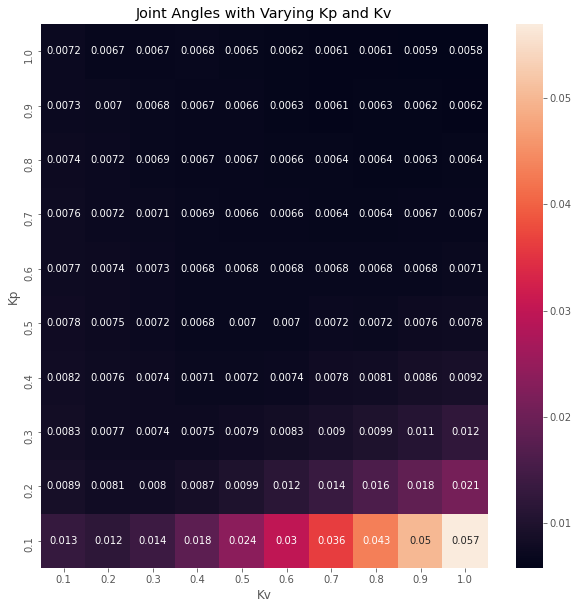

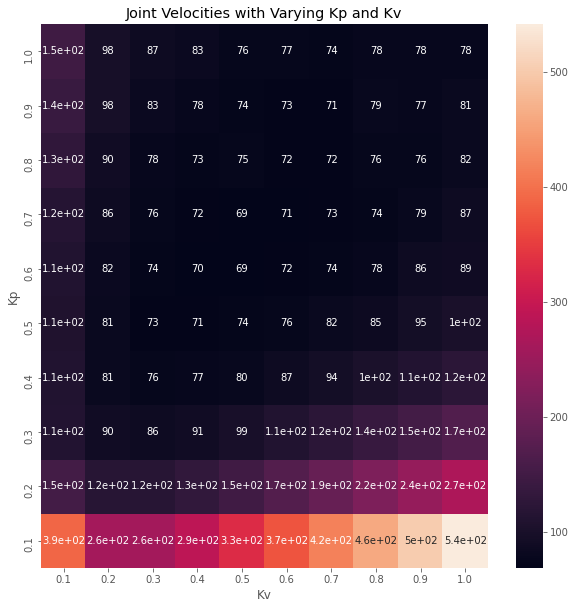

In [3]:
#: Plot heatmap
joint_angles_MSE_df, joint_angles_MSE_dict = calculate_MSE_joints(joint_angles,baseline_position,beg=100)
joint_vel_MSE_df, joint_vel_MSE_dict = calculate_MSE_joints(joint_velocities,baseline_velocity,beg=100)

pivot_pos, pivot_vel = 0, 0
for leg in legs:
    temp_pos = joint_angles_MSE_df.loc[joint_angles_MSE_df['Leg']==leg,:]
    pivot_pos += temp_pos.pivot(index='Kp', columns='Kv', values='MSE')
    temp_vel = joint_vel_MSE_df.loc[joint_vel_MSE_df['Leg']==leg,:]
    pivot_vel += temp_vel.pivot(index='Kp', columns='Kv', values='MSE')

fig, ax = plt.subplots(figsize=(10,10)) 
plot_heatmap(pivot_pos,ax, "Joint Angles with Varying Kp and Kv")
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) 
plot_heatmap(pivot_vel,ax, "Joint Velocities with Varying Kp and Kv")
plt.show()

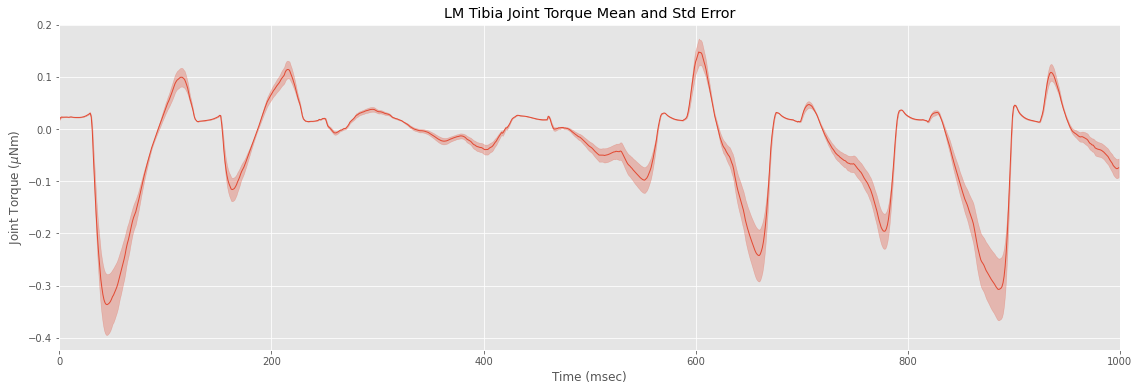

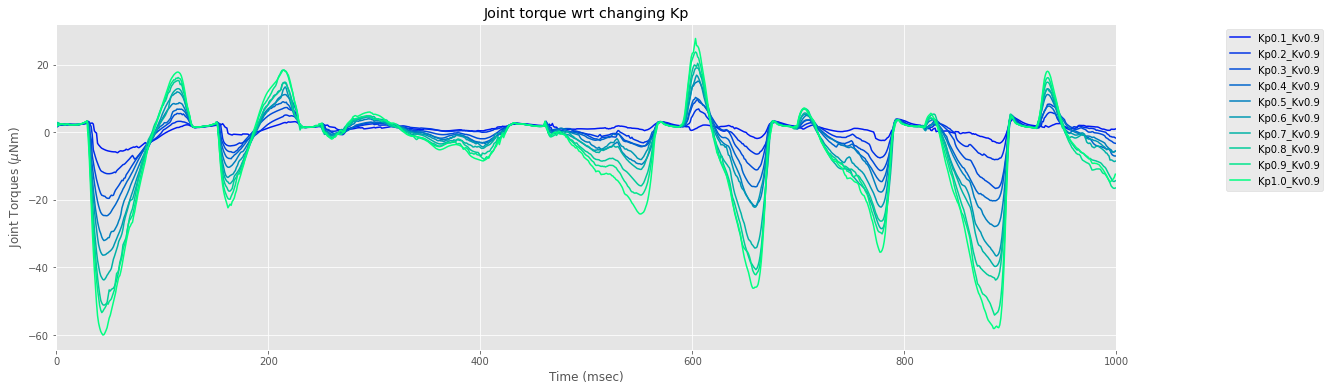

In [8]:
########################################### JOINT TORQUES ###########################################
torques_stat = calculate_statistics_joints(
        joint_torques, 
        scaling_factor = 1, 
        constant = 'Kv0.9', 
        force_calculation = False, 
        joints = ['Coxa', 'Coxa_yaw', 'Coxa_roll', 'Femur', 'Femur_roll', 'Tibia', 'Tarsus1']
        )

beg = 900
end = 2900 
joint = 'joint_LMCoxa'
unit = '$\mu$Nm'

# Plot standard error and mean of one single joint torque
fig, ax = plt.subplots(figsize=(19,6))
plot_mu_sem(
               mu=torques_stat['mu'][joint][beg:end],
               error=torques_stat['stderr'][joint][beg:end],
               ax=ax
               )

ax.set(
        xlabel='Time (msec)', 
        ylabel='Joint Torque ($\mu$Nm)', 
        title='LM Tibia Joint Torque Mean and Std Error'
        )
plt.xlim(0,end-beg)
plt.savefig('torque_stderror_{}.png'.format(joint))
plt.show()

# Plot torque of one single joint 

fig, ax = plt.subplots(figsize=(19,6))
plot_kp_joint(
        joint_torques, 
        show_vector=False, 
        calc_force=False,
        full_name=joint, 
        ax=ax, 
        constant='Kv0.9', 
        condition='Kp0.4_Kv0.9',
        beg=beg, 
        intv=end-beg
        ) 

ax.set(
        xlabel='Time (msec)', 
        ylabel='Joint Torques ({})'.format(unit), 
        title='LM Tibia Joint Torque wrt Changing Kp'
        )
plt.xlim(0,end-beg)
plt.savefig('torque_kp_LMCoxa.png')

plt.show()

In [ ]:
########################################### GROUND REACTION FORCES ###########################################
GRF_stat = calculate_statistics_joints(
        ground_contact_forces, 
        scaling_factor = 1, 
        constant = 'Kv0.9', 
        force_calculation = True, 
        )

beg = 900
end = 2900 
joint = 'LM'
unit = 'mN'

# Plot standard error and mean of one single leg GRF
fig, ax = plt.subplots(figsize=(19,6))
plot_mu_sem(
               mu=GRF_stat['mu'][joint][beg:end],
               error=GRF_stat['stderr'][joint][beg:end],
               ax=ax
               )

ax.set(
        xlabel='Time (msec)', 
        ylabel='GRF ({})'.format(unit), 
        title='Left Middle Leg GRF Mean and Std Error'
        )
plt.xlim(0,end-beg)
plt.savefig('GRF_stderror_{}.png'.format(joint))
plt.show()


# Plot one single leg GRF 

fig, ax = plt.subplots(figsize=(19,6))
plot_kp_joint(
        ground_contact_forces, 
        show_vector=False, 
        calc_force=True,
        full_name=joint, 
        ax=ax, 
        constant='Kv0.9', 
        condition='Kp0.4_Kv0.9',
        beg=beg, 
        intv=end-beg
        ) 

ax.set(
        xlabel='Time (msec)', 
        ylabel='Ground Reaction Forces ({})'.format(unit), 
        title='Left Middle Leg Ground Reaction Forces wrt Changing Kp'
        )
plt.xlim(0,end-beg)
plt.savefig('GRF_kp_{}_single.png'.format(joint))

plt.show()


# Plot the vector of one single leg GRF

fig, ax = plt.subplots(figsize=(19,6))
plot_kp_joint(
        ground_contact_forces, 
        show_vector=True, 
        calc_force=True,
        full_name=joint, 
        ax=ax, 
        constant='Kv0.9', 
        condition='Kp0.4_Kv0.9',
        beg=beg, 
        intv=end-beg
        ) 

ax.set(
        xlabel='Time (msec)', 
        ylabel='Ground Reaction Forces ({})'.format(unit), 
        title='Left Middle Leg Ground Reaction Forces wrt Changing Kp'
        )
plt.xlim(0,end-beg)
plt.savefig('GRF_kp_{}.png'.format(joint))

plt.show()

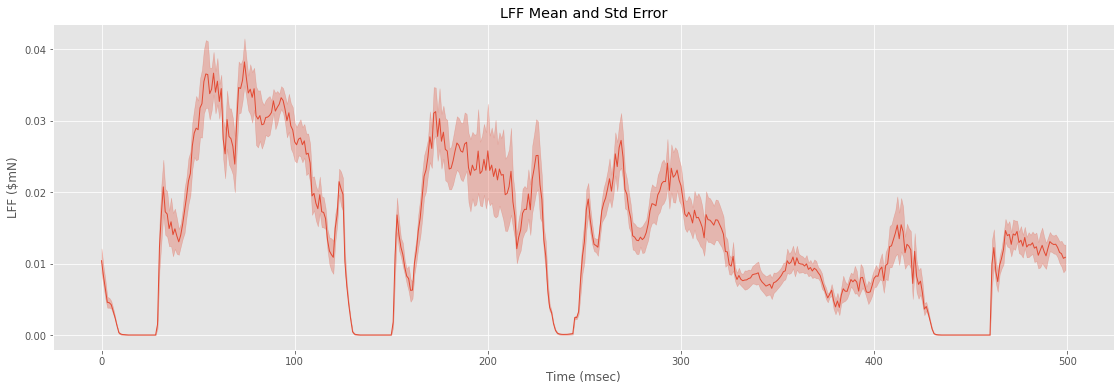

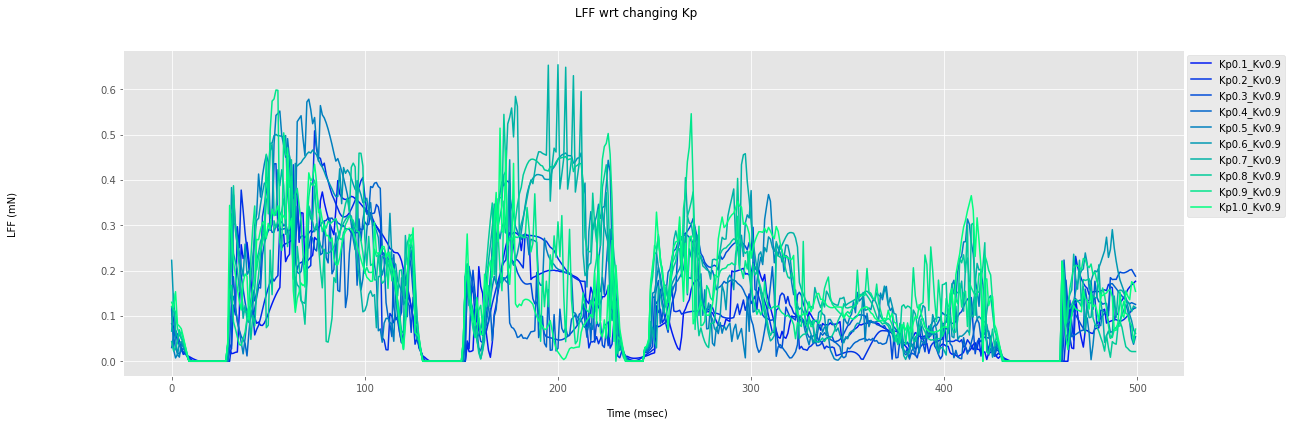

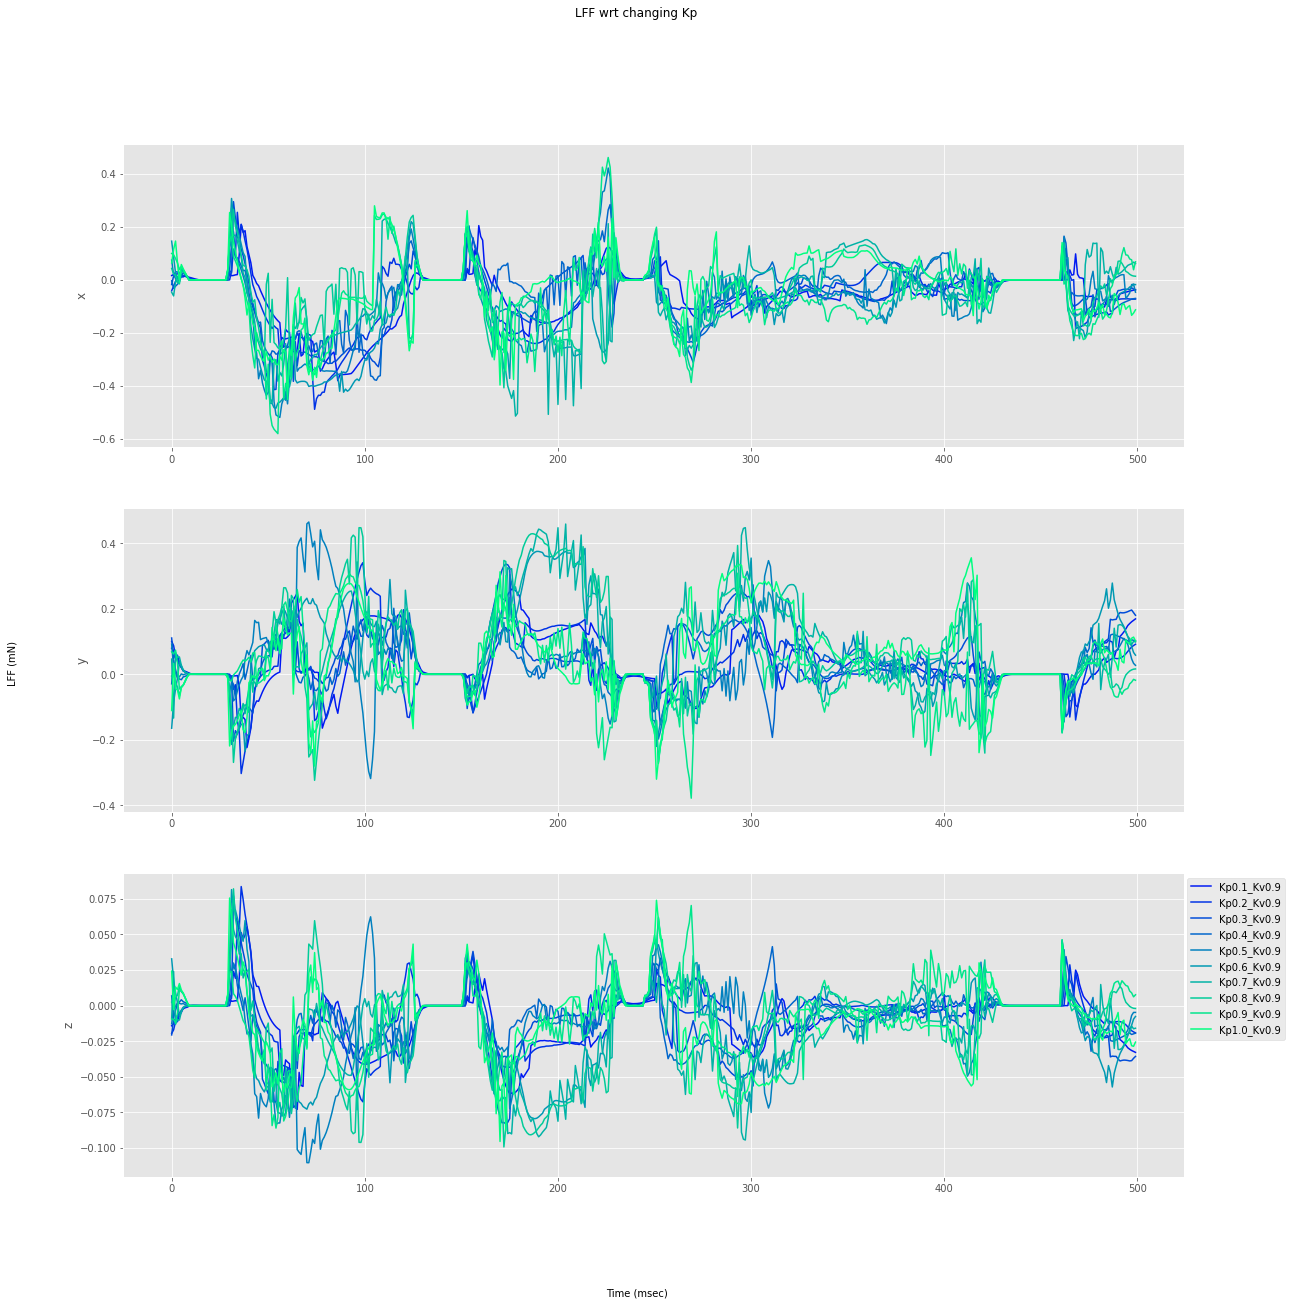

In [22]:
########################################### LATERAL FRICTION FORCES ###########################################
LFF_stat = calculate_statistics_joints(
        ground_friction_dir1, 
        ground_friction_dir2,
        scaling_factor = 1, 
        constant = 'Kv0.9', 
        force_calculation = True, 
        )

beg = 900
end = 2900 
joint = 'LM'
unit = 'mN'

# Plot standard error and mean of one single leg LFF
fig, ax = plt.subplots(figsize=(19,6))
plot_mu_sem(
               mu=LFF_stat['mu'][joint][beg:end],
               error=LFF_stat['stderr'][joint][beg:end],
               ax=ax
               )

ax.set(
        xlabel='Time (msec)', 
        ylabel='LFF ({})'.format(unit), 
        title='Left Middle Leg GRF Mean and Std Error'
        )
plt.xlim(0,end-beg)
plt.savefig('LFF_stderror_{}.png'.format(joint))
plt.show()


# Plot one single leg LFF 

fig, ax = plt.subplots(figsize=(19,6))
plot_kp_joint(
        ground_contact_forces, 
        show_vector=False, 
        calc_force=True,
        full_name=joint, 
        ax=ax, 
        constant='Kv0.9', 
        condition='Kp0.4_Kv0.9',
        beg=beg, 
        intv=end-beg
        ) 

ax.set(
        xlabel='Time (msec)', 
        ylabel='Ground Reaction Forces ({})'.format(unit), 
        title='Left Middle Leg Ground Reaction Forces wrt Changing Kp'
        )
plt.xlim(0,end-beg)
plt.savefig('LFF_kp_{}_one.png'.format(joint))

plt.show()


# Plot the vector of one single leg LFF

fig, ax = plt.subplots(figsize=(19,6))
plot_kp_joint(
        ground_contact_forces, 
        show_vector=True, 
        calc_force=True,
        full_name=joint, 
        ax=ax, 
        constant='Kv0.9', 
        condition='Kp0.4_Kv0.9',
        beg=beg, 
        intv=end-beg
        ) 

ax.set(
        xlabel='Time (msec)', 
        ylabel='Ground Reaction Forces ({})'.format(unit), 
        title='Left Middle Leg Ground Reaction Forces wrt Changing Kp'
        )
plt.xlim(0,end-beg)
plt.savefig('LFF_kp_{}.png'.format(joint))

plt.show()

In [50]:
########################################### FORCES ON THE TETHERING POINTS ###########################################
fig, ax = plt.subplots(figsize=(12,9))
plt.title('Forces Measured on the Thorax')
plot_stance_force(
    data=thorax_forces,
    grf_forces=ground_contact_forces,
    show_stance=True,
    show_weight=True,
    ax=ax,
    start=beg,
    stop=end)
plt.xlim(0,end-beg)

plt.savefig('thorax_forces_kp.png')


stack_array = calculate_stack_array(
    thorax_forces, 
    force_cal=True,
    leg='')
thorax_stat = calculate_stats(stack_array)


beg = 900
end = 2900 
unit = 'mN'

# Plot standard error and mean of one single leg GRF
fig, ax = plt.subplots(figsize=(19,6))
plot_mu_sem(
               mu=thorax_stat['mu'][beg:end],
               error=thorax_stat['stderr'][beg:end],
               ax=ax
               )

ax.set(
        xlabel='Time (msec)', 
        ylabel='Thorax Measurement ({})'.format(unit), 
        title='Thorax Measurements Mean and Std Error'
        )
plt.xlim(0,end-beg)
plt.savefig('thorax_stderror_{}.png'.format(joint))
plt.show()


(0.0, 2000.0)

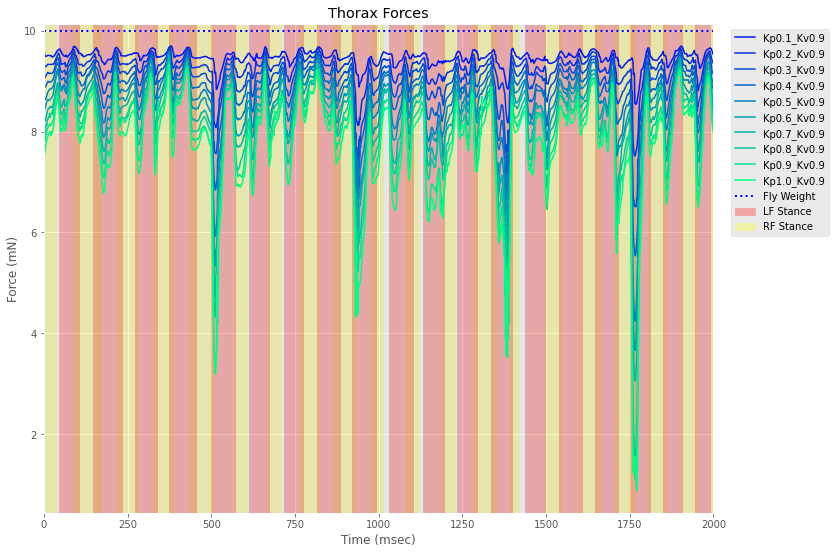

In [30]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

problem = {
    'num_vars': 2,
    'names': ['kp', 'kv'],
    'bounds': [[0, 1],
               [0, 1]]
               }
param_values = saltelli.sample(problem, 10)
print(param_values)

[[0.21972656 0.09667969]
 [0.51855469 0.09667969]
 [0.21972656 0.67675781]
 [0.21972656 0.67675781]
 [0.51855469 0.09667969]
 [0.51855469 0.67675781]
 [0.71972656 0.59667969]
 [0.01855469 0.59667969]
 [0.71972656 0.17675781]
 [0.71972656 0.17675781]
 [0.01855469 0.59667969]
 [0.01855469 0.17675781]
 [0.96972656 0.34667969]
 [0.76855469 0.34667969]
 [0.96972656 0.92675781]
 [0.96972656 0.92675781]
 [0.76855469 0.34667969]
 [0.76855469 0.92675781]
 [0.46972656 0.84667969]
 [0.26855469 0.84667969]
 [0.46972656 0.42675781]
 [0.46972656 0.42675781]
 [0.26855469 0.84667969]
 [0.26855469 0.42675781]
 [0.34472656 0.47167969]
 [0.14355469 0.47167969]
 [0.34472656 0.30175781]
 [0.34472656 0.30175781]
 [0.14355469 0.47167969]
 [0.14355469 0.30175781]
 [0.84472656 0.97167969]
 [0.64355469 0.97167969]
 [0.84472656 0.80175781]
 [0.84472656 0.80175781]
 [0.64355469 0.97167969]
 [0.64355469 0.80175781]
 [0.59472656 0.22167969]
 [0.39355469 0.22167969]
 [0.59472656 0.05175781]
 [0.59472656 0.05175781]
